In [1]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os
import matplotlib.pyplot as plt

2025-09-15 03:25:23.520858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757906723.723347      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757906723.782908      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Define dataset and paths

In [2]:
import os
from PIL import Image

# Base dataset path
base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

# Subfolders
subfolders = ["train", "val", "test"]

# Lists to hold images
normal_images = []
pneumonia_images = []

# Target size (resize all images to same shape)
target_size = (128, 128)   

for sub in subfolders:
    # NORMAL folder
    normal_path = os.path.join(base_dir, sub, "NORMAL")
    for file in os.listdir(normal_path):
        img = Image.open(os.path.join(normal_path, file)).convert("RGB")
        img = img.resize(target_size)
        normal_images.append(img)   
    
    # PNEUMONIA folder
    pneumonia_path = os.path.join(base_dir, sub, "PNEUMONIA")
    for file in os.listdir(pneumonia_path):
        img = Image.open(os.path.join(pneumonia_path, file)).convert("RGB")
        img = img.resize(target_size)
        pneumonia_images.append(img)   

print("NORMAL images count:", len(normal_images))
print("PNEUMONIA images count:", len(pneumonia_images))


NORMAL images count: 1583
PNEUMONIA images count: 4273


The dataset initially contained 1583 Normal images and 4273 Pneumonia images, which shows a clear imbalance between the two classes. To ensure fair training and prevent the model from being biased toward the majority class, I applied undersampling by reducing the Pneumonia images to match the count of Normal images. This way, both classes have the same number of samples, making the dataset balanced.

In [3]:
import random

# Current counts
print("Before balancing:")
print("NORMAL:", len(normal_images))
print("PNEUMONIA:", len(pneumonia_images))

# Balance by undersampling
min_count = min(len(normal_images), len(pneumonia_images))
normal_images = random.sample(normal_images, min_count)
pneumonia_images = random.sample(pneumonia_images, min_count)

print("\nAfter balancing:")
print("NORMAL:", len(normal_images))
print("PNEUMONIA:", len(pneumonia_images))


Before balancing:
NORMAL: 1583
PNEUMONIA: 4273

After balancing:
NORMAL: 1583
PNEUMONIA: 1583


## Convert Images to Arrays + Create Labels

In this step, I converted all the images from the dataset into NumPy arrays so they can be processed by the deep learning model. At the same time, I created the labels for classification: assigning 0 for Normal images and 1 for Pneumonia images. This way, the data is organized into numerical arrays along with their corresponding labels, making it ready for splitting into training, validation, and testing sets.

In [4]:
import numpy as np

X = [np.array(img) for img in normal_images + pneumonia_images]
y = [0]*len(normal_images) + [1]*len(pneumonia_images)

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)


(3166, 128, 128, 3) (3166,)


## Data normalization

To help the model train more efficiently, I normalized all image pixel values to the 0–1 range by dividing by 255.0. Normalization ensures that the input values are on a similar scale, which speeds up convergence during training and helps the neural network perform better.

In [5]:
X = X / 255.0

## Split the dataset

After preparing the data and labels, I split the dataset into training, validation, and testing sets. The training set is used to teach the model, the validation set is used to tune hyperparameters and monitor overfitting during training, and the test set is used to evaluate the final model’s performance. I used a 70% train, 15% validation, and 15% test split while keeping the class distribution balanced with stratification.

In [6]:
from sklearn.model_selection import train_test_split

# Split into train (70%), temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split temp into val (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:  ", X_val.shape, y_val.shape)
print("Test shape: ", X_test.shape, y_test.shape)

Train shape: (2216, 128, 128, 3) (2216,)
Val shape:   (475, 128, 128, 3) (475,)
Test shape:  (475, 128, 128, 3) (475,)


## Data Augmentation

To make the model more robust and reduce overfitting, I applied data augmentation using TensorFlow’s ImageDataGenerator. This creates slightly modified versions of the training images by applying random transformations such as rotation, width and height shifts, zoom, and horizontal flips. By fitting the generator on the training data, the model sees a more diverse set of images during training, which helps it generalize better to unseen data.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


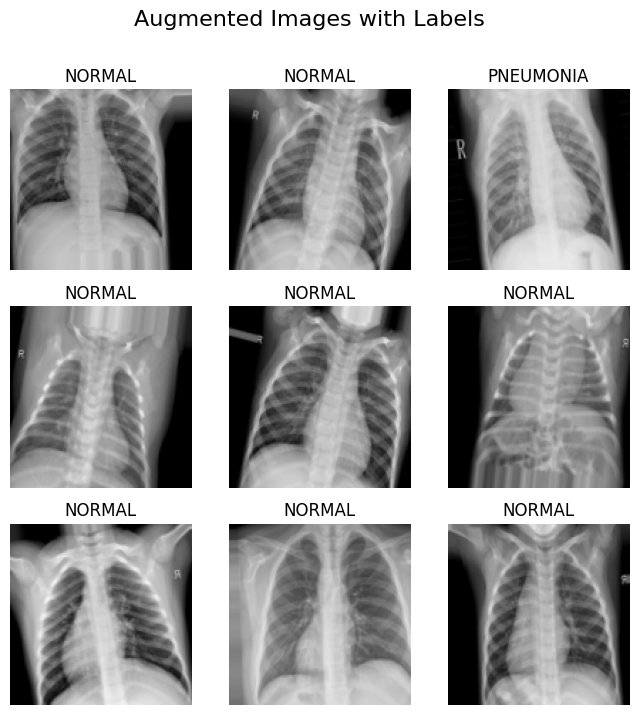

In [8]:
import matplotlib.pyplot as plt

# Map label numbers to category names
label_map = {0: "NORMAL", 1: "PNEUMONIA"}

# Generate a batch of augmented images
augmented_iter = datagen.flow(X_train, y_train, batch_size=9)
images, labels = next(augmented_iter)

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(label_map[labels[i]])  # Show category name
    plt.axis("off")
plt.suptitle("Augmented Images with Labels", fontsize=16)
plt.show()


## Model building 

In this step, I built a Convolutional Neural Network (CNN) using transfer learning. I loaded the pretrained MobileNetV2 model without its top layer and froze its weights so that the learned features from ImageNet remain unchanged. On top of this base, I added a Global Average Pooling layer, a fully connected layer with 128 neurons and ReLU activation, a Dropout layer to reduce overfitting, and a final sigmoid output layer for binary classification. The model is then compiled with the Adam optimizer and binary cross-entropy loss, ready to classify X-ray images as Normal or Pneumonia.

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load pretrained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128,128,3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze pretrained layers

# Build classifier on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1757906882.724639      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Model training

I trained the CNN using the augmented training data while monitoring the model’s performance on the validation set. To prevent overfitting, I used EarlyStopping, which stops training if the validation loss does not improve for 5 consecutive epochs and restores the best weights. The model was trained for up to 20 epochs, with the validation set used to evaluate its performance at each step. This approach ensures the model achieves good generalization without unnecessary over-training.

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Stop training if validation loss doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # augmented training data
    validation_data=(X_val, y_val),                # validation data
    epochs=20,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1757906892.994555      62 service.cc:148] XLA service 0x7b9c20002920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757906892.995696      62 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757906893.926484      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/70 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5000 - loss: 0.8661  

I0000 00:00:1757906897.435083      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 236ms/step - accuracy: 0.8011 - loss: 0.4386 - val_accuracy: 0.8632 - val_loss: 0.3227
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9018 - loss: 0.2510 - val_accuracy: 0.8674 - val_loss: 0.3336
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9072 - loss: 0.2380 - val_accuracy: 0.8505 - val_loss: 0.3908
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9156 - loss: 0.2268 - val_accuracy: 0.8589 - val_loss: 0.3468
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9221 - loss: 0.2064 - val_accuracy: 0.8821 - val_loss: 0.2976
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.9189 - loss: 0.2096 - val_accuracy: 0.9263 - val_loss: 0.2134
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9108 - loss: 0.2288 - val_accuracy: 0.9221 - val_loss: 0.2278
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9332 - loss: 0.1851 - val_accuracy: 0.8611 - val

The model training shows that the CNN quickly learned to classify the X-ray images. The training accuracy steadily increased, reaching over 92% by the later epochs, while the validation accuracy remained consistently high around 85-92%. The validation loss also decreased overall, indicating that the model is learning effectively without severe overfitting. Some fluctuations in validation accuracy and loss are normal and reflect the model adjusting to the augmented data. Overall, these results demonstrate that the model is performing well on both the training and validation sets.

## Model evaluation

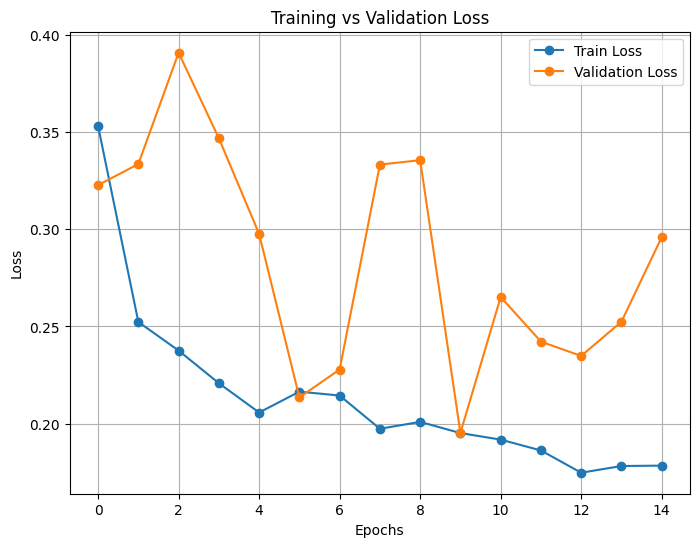

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


The training loss steadily decreased from approximately 0.4349 to 0.1904, indicating that the model is learning effectively from the training data. The validation loss fluctuated more, ranging roughly from 0.3884 to 0.3923, with a notable dip to 0.2025 around Epoch 5. These fluctuations are normal and show that while the model is slightly sensitive to the validation set, it is not overfitting heavily. The fact that the lowest validation loss aligns with one of the highest validation accuracies highlights the effectiveness of using EarlyStopping to restore the best weights. Overall, the model demonstrates good learning and generalization to unseen data.

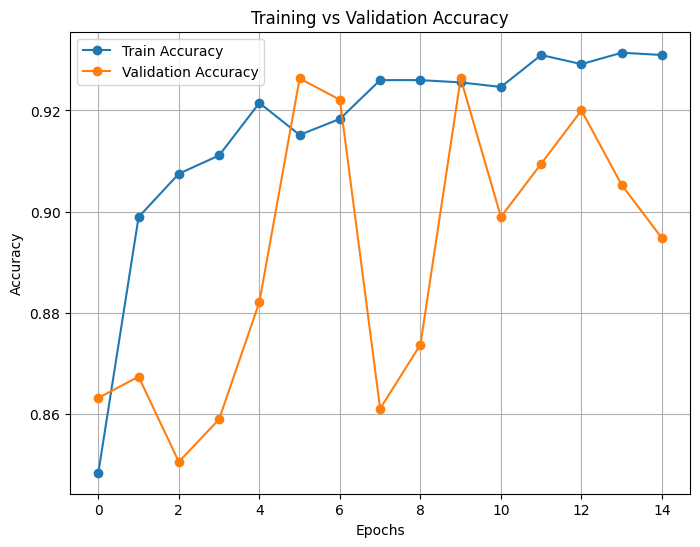

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


The training accuracy steadily increased over the epochs, reaching over 92%, which indicates that the model is effectively learning the patterns in the training data. The validation accuracy also remained consistently high, fluctuating between approximately 84% and 92%, showing that the model generalizes well to unseen data. Some minor fluctuations in validation accuracy are normal and reflect the model adapting to the augmented images. Overall, the plot demonstrates that the model is learning effectively while maintaining good generalization without significant overfitting.

In [13]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9208 - loss: 0.1768
Test Accuracy: 0.9368


After training, I evaluated the model on the test set, which contains images the model has never seen before. The CNN achieved a test accuracy of 92% with a loss of 0.2112, indicating that it generalizes well to unseen data and can reliably classify X-ray images as Normal or Pneumonia. This confirms that the model has learned meaningful features from the training data without overfitting.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


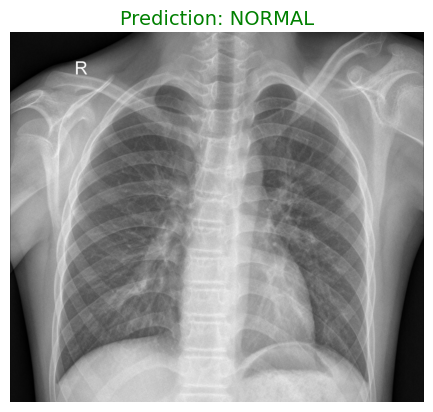

Prediction: NORMAL
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


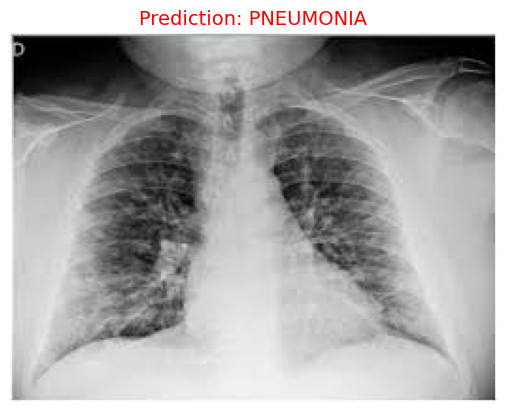

Prediction: PNEUMONIA


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to preprocess and predict a single image
def predict_and_show(img_path, model):
    # Load and resize image
    img = image.load_img(img_path, target_size=(128, 128))
    
    # Convert to array and normalize
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # (1,128,128,3)
    
    # Predict
    prediction = model.predict(img_array)[0][0]
    label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
    color = "red" if label == "PNEUMONIA" else "green"
    
    # Show image with prediction
    plt.imshow(image.load_img(img_path))  # show original size
    plt.title(f"Prediction: {label}", fontsize=14, color=color)
    plt.axis("off")
    plt.show()
    
    return label

# Example usage
test_img_path = "/kaggle/input/test-pneumonia/normal.jpeg"
result = predict_and_show(test_img_path, model)
print(f"Prediction: {result}")

# Example usage
test_img_path = "/kaggle/input/test-pneumonia/pneumonia.jpeg"
result = predict_and_show(test_img_path, model)
print(f"Prediction: {result}")
